In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import helper.helper as h
import statsmodels.api as sm
from tqdm import tqdm

from notears.notears.notears import utils
from notears.notears.notears import linear

In [3]:
def k_ols_W(Psi, P):
    # translate X
    psi = P @ Psi @ P.T
    W_hat = np.zeros((p, p))

    # get parameters
    for i in range(1, p):
        psi_F = psi[np.array(range(i))[:, None], np.array(range(i))[None, :]]   
        W_hat[np.array(range(i))[:, None], i] = np.linalg.inv(psi_F) @ psi[np.array(range(i))[:, None], i]

    return P.T @ W_hat @ P

def ols_W(X, P):
    # translate X
    x = X @ P.T

    W_hat = np.array(np.zeros(p)).T

    # get parameters
    for i in range(p):
        if i == 0:
            W_hat = np.vstack((W_hat, np.zeros(p)))
        else:
            est = sm.OLS(x[:, i], x[:, :i]).fit()   
            W_hat = np.vstack((W_hat, np.append(est.params, np.zeros(p - i)).T))

    return P.T @ W_hat[1:].T @ P

def ols_W_full(X):
    # translate X
    x = X

    W_hat = np.array(np.zeros(p)).T

    # get parameters
    for i in range(p):
        est = sm.OLS(x[:, i], np.delete(x, i, axis = 1)).fit()  
        W_hat = np.vstack((W_hat, np.append(est.params[:i], np.append(0, est.params[i:])).T)) 
        # W_hat = np.vstack((W_hat, np.append(est.params, np.zeros(1)).T))

    return W_hat[1:].T

In [4]:
def generate_U(p, num_edges, low = 0.5, high = 2.0, tril = False):
    edges = np.array([0.0] * (int(p * (p + 1) / 2) - num_edges - p * tril) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(low, high, num_edges)
    np.random.shuffle(edges)
    
    U = np.zeros((p, p))
    
    U[np.tril_indices(p, - tril)] = edges
    
    return U

In [8]:
utils.set_random_seed(1)

T, p, s0, graph_type, sem_type = 1000, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {p} nodes and {s0} edges, {T} samples.")

B_true = utils.simulate_dag(p, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = utils.simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = utils.simulate_linear_sem(W_true, T, sem_type)
Psi = np.dot(X.T, X)

W_est, h_val = linear.notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)

print(loss(W_est, X))

SEM based on a graph on 5 nodes and 5 edges, 1000 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5 -1.9]
 [-1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.1]
 [ 0.   0.  -0.9  0.   0. ]].

Estimated WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.6 -1.9]
 [-1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.1]
 [ 0.   0.  -0.9  0.   0. ]].

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}


NameError: name 'loss' is not defined

In [11]:
order = h.is_dag(B_true)[1]
P_true = np.zeros((p, p))
for i in range(p):
    P_true[order[-i]][i] = 1

print(P_true)
print(np.round(k_ols_W(Psi, P_true), 2))

order = h.is_dag(B_true)[1]
P = np.zeros((p, p))
for i in range(p):
    P[i][order[-i]] = 1

print(P)
print(np.round(ols_W(X, P.T), 2))

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
[[ 0.   -0.13 -0.4  -0.01  0.34]
 [ 0.    0.   -0.02  1.19 -0.52]
 [ 0.    0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.19  0.51  0.  ]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]
[[ 0.   -0.13 -0.4  -0.01  0.34]
 [ 0.    0.   -0.02  1.19 -0.52]
 [ 0.    0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.19  0.51  0.  ]]


In [12]:
def sample_next_P(P):  
    # get copy
    P_return = P.copy()
    
    # get the two rows to swap
    i, j = np.random.choice(p, 2, replace = False)
    
    # swap row i and row j
    P_return[[i, j]] = P_return[[j, i]]
    
    # return new sample
    return P_return

In [45]:
def loss(W, X):
    return 1 / T * np.linalg.norm(X - X @ W, 'f') ** 2

def expected_MSE_X(W):
    return np.linalg.inv(np.identity(p) - W).T @ np.linalg.inv(np.identity(p) - W)

def true_loss(W_est, W_true):
    return np.trace((W_est - np.identity(p)).T @ expected_MSE_X(W_true) @ (W_est- np.identity(p)))

def get_likelihood(P):
    # get optimal A for this permutation
    W_opt = k_ols_W(Psi, P)

    # get loss    
    return loss(W_opt, X)

print(np.round(k_ols_W(np.dot(X.T, X), P_true), 2))
print(np.round(ols_W(X, P_true), 2))
print(loss(ols_W(X, P_true), X))
print(loss(k_ols_W(Psi, P_true), X))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 7)

In [62]:
L_ols = loss(ols_W_full(X), X)
k = 2

def acc_prob_reg(L, L_new):
    return min(L / L_new, 1)

def acc_prob_trans(L, L_new, L_ols = L_ols):
    return min((L - L_ols) / (L_new - L_ols), 1)

def acc_prob_pow(L, L_new, k = k):
    return min((L / L_new) ** k, 1)

def acc_prob_trans_pow(L, L_new, k = k, L_ols = L_ols):
    return min(((L - L_ols) / (L_new - L_ols)) ** k, 1)

def acc_prob_greed(L, L_new, k = k, L_ols = L_ols):
    return L_new < L

def mcmc(max_it, verbose = False, P = np.identity(p), factor = 1.0, acc_prob = acc_prob_reg, total_time = 1e10):
    start = timer()
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = get_likelihood(P) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    results_l_transition = []
    results_l_next = []
    num_missed_edges = []

    # transitions
    transitions = 0
    
    for i in tqdm(range(max_it)):   
        # check if time has passed
        if timer() - start > total_time: 
            break
            
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = get_likelihood(P_prime)
        alpha = acc_prob(likelihood_P, likelihood_P_prime)
        
        # print results
        if verbose:
            print(f"Iteration {i+1}.\n")
            print(f"Old P:\n{P}\nLikelihood: {round(likelihood_P, 2)}\n\nNew P:\n{P_prime}\nLikelihood: {round(likelihood_P_prime, 2)}.")
            print(f"\nAcceptance probability: {round(alpha, 3)}.")
    
        # prepare for next iteration
        if np.random.rand() <= alpha:
            transitions += 1
            P, likelihood_P = P_prime, likelihood_P_prime
            results_l_transition.append(likelihood_P_prime)
            # save best
            if likelihood_P < L_best:
                L_best = likelihood_P
                P_best = P
        
        # results
        results_l_next.append(likelihood_P_prime)
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ B_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    if verbose:
        print(transitions)
        print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, results_l_transition, results_l_next, num_missed_edges]

def rw(max_it, verbose = False, P = np.identity(p), factor = 1.0):
    # initial value
    likelihood_P = get_likelihood(P)

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    num_missed_edges = []
    for i in tqdm(range(max_it)):   
        # sample next P
        P = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P = get_likelihood(P)
        
        # save best
        if likelihood_P < L_best:
            L_best = likelihood_P
            P_best = P
                
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ B_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, num_missed_edges]

In [34]:
n_iter = 500
np.random.seed(seed = 123)
P, r = mcmc(n_iter, False, acc_prob = acc_prob_reg)
W_mcmc = ols_W(X, P)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = utils.count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prt, rt = mcmc(n_iter, False, acc_prob = acc_prob_trans)
W_mcmc = ols_W(X, Prt)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = utils.count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prp, rp = mcmc(n_iter, False, acc_prob = acc_prob_pow)
W_mcmc = ols_W(X, Prp)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = utils.count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prtp, rtp = mcmc(n_iter, False, acc_prob = acc_prob_trans_pow)
W_mcmc = ols_W(X, Prtp)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = utils.count_accuracy(B_true, W_mcmc != 0)
print(acc)

np.random.seed(seed = 123)
Prtg, rg = mcmc(n_iter, False, acc_prob = acc_prob_greed)
W_mcmc = ols_W(X, Prtg)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = utils.count_accuracy(B_true, W_mcmc != 0)
print(acc)
np.random.seed(seed = 123)

rwP, rw_l = rw(n_iter, False)
W_mcmc = ols_W(X, rwP)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = utils.count_accuracy(B_true, W_mcmc != 0)
print(acc)

 23%|██████████████████▎                                                           | 117/500 [00:00<00:00, 1169.98it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}


 13%|██████████▌                                                                     | 66/500 [00:00<00:00, 653.47it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}


 16%|████████████▋                                                                   | 79/500 [00:00<00:00, 789.99it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}


 35%|███████████████████████████▍                                                   | 174/500 [00:00<00:00, 863.44it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}


 18%|██████████████▋                                                                 | 92/500 [00:00<00:00, 918.28it/s]

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 904.15it/s]

Best permutation:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]

Likelihood: 4.28.
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}


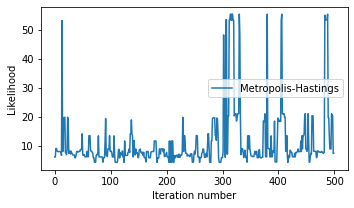

In [35]:
fig = plt.figure(figsize = (5.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(np.array(r[0]), label = "Metropolis-Hastings")
# plt.plot(np.array(rw_l[0]), label = "Random Walk")
plt.legend()

Suitable permutation found: True.
10 out of 10 edges recovered.


NameError: name 'al_list' is not defined

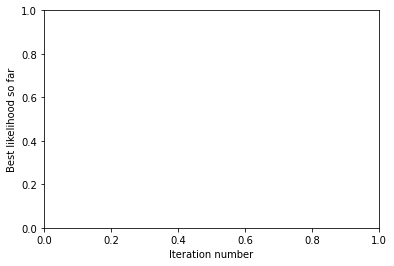

In [36]:
# verify whether the permutation is campatible
check = P @ W_true @ P.T
check_triu = np.triu(check)
print(f"Suitable permutation found: {len(check_triu[check_triu != 0]) == s0}.")
print(f"{len(check_triu[check_triu != 0])} out of {s0} edges recovered.")
plt.xlabel("Iteration number")
plt.ylabel("Best likelihood so far")
plt.plot(np.array(al_list) + 0)
plt.plot(rw_l_list)

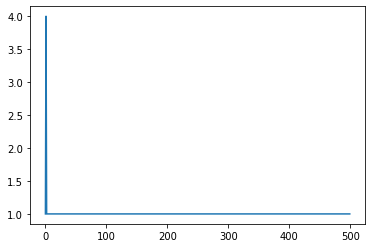

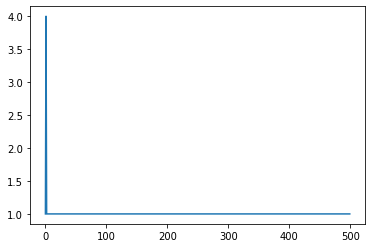

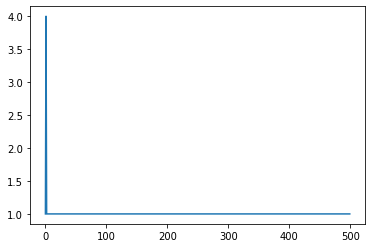

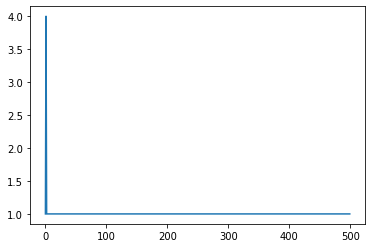

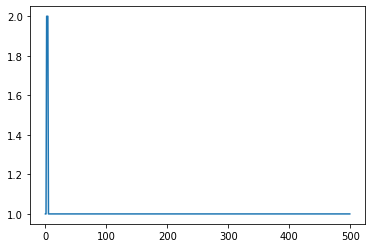

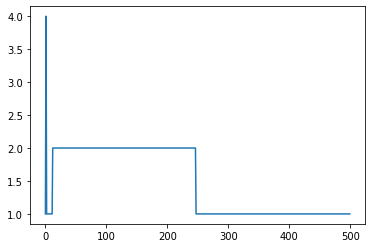

In [24]:
plt.plot(s0 - np.array(r[-1]))
plt.show()
plt.plot(s0 - np.array(rp[-1]))
plt.show()
plt.plot(s0 - np.array(rt[-1]))
plt.show()
plt.plot(s0 - np.array(rtp[-1]))
plt.show()
plt.plot(s0 - np.array(rg[-1]))
plt.show()
plt.plot(s0 - np.array(rw_l[-1]))

Regular MCMC
8.549842122908844
7.1635957235117305
Squared MCMC
8.149914011490663
7.027902083744635
Translated MCMC
8.216307490066786
7.1635957235117305
Squared Translated MCMC
7.09213089049399
6.812207013665513
Greedy MCMC
4.989951878523354
4.959025586090357
RW
10.187716463441573
7.296467014436083


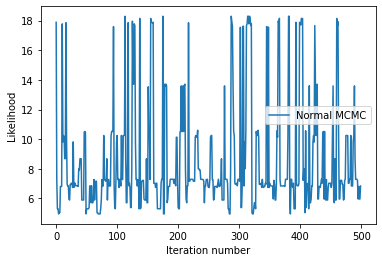

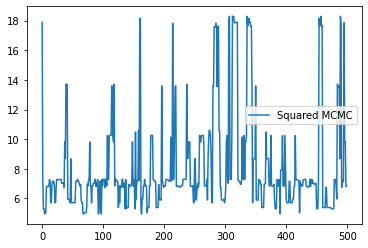

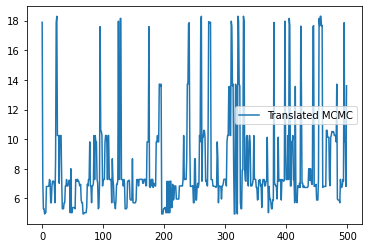

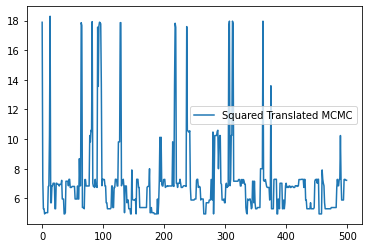

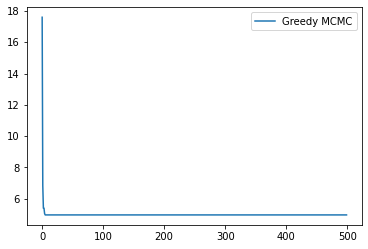

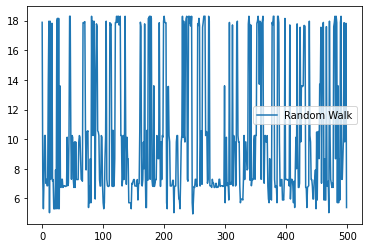

In [25]:
print("Regular MCMC")
print(np.mean(np.array(r[0])))
print(np.median(np.array(r[0])))

print("Squared MCMC")
print(np.mean(np.array(rp[0])))
print(np.median(np.array(rp[0])))

print("Translated MCMC")
print(np.mean(np.array(rt[0])))
print(np.median(np.array(rt[0])))

print("Squared Translated MCMC")
print(np.mean(np.array(rtp[0])))
print(np.median(np.array(rtp[0])))

print("Greedy MCMC")
print(np.mean(np.array(rg[0])))
print(np.median(np.array(rg[0])))

print("RW")
print(np.mean(np.array(rw_l[0])))
print(np.median(np.array(rw_l[0])))

plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(r[0], label = "Normal MCMC")
plt.legend()

plt.show()
plt.plot(rp[0], label = "Squared MCMC")
plt.legend()

plt.show()
plt.plot(rt[0], label = "Translated MCMC")
plt.legend()

plt.show()
plt.plot(rtp[0], label = "Squared Translated MCMC")
plt.legend()

plt.show()
plt.plot(rg[0], label = "Greedy MCMC")
plt.legend()
plt.show()

plt.show()
plt.plot(rw_l[0], label = "Random Walk")
plt.legend()
plt.show()

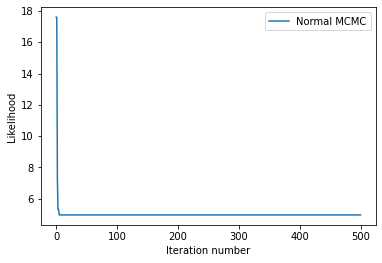

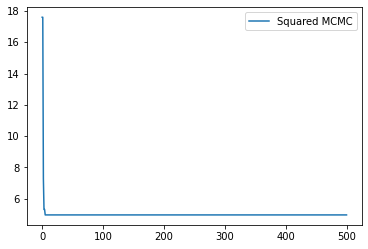

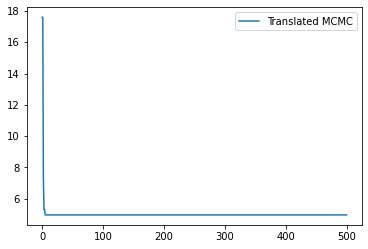

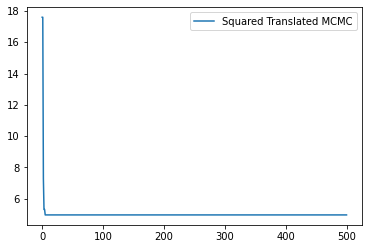

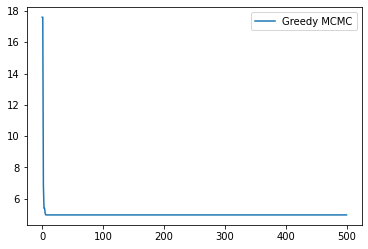

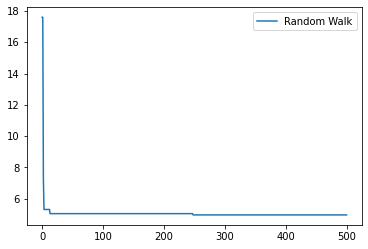

In [26]:
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(r[1], label = "Normal MCMC")
plt.legend()

plt.show()
plt.plot(rp[1], label = "Squared MCMC")
plt.legend()

plt.show()
plt.plot(rt[1], label = "Translated MCMC")
plt.legend()

plt.show()
plt.plot(rtp[1], label = "Squared Translated MCMC")
plt.legend()

plt.show()
plt.plot(rg[1], label = "Greedy MCMC")
plt.legend()
plt.show()

plt.show()
plt.plot(rw_l[1], label = "Random Walk")
plt.legend()
plt.show()

In [27]:
print("Metropolis Hastings.")
print(f"MSE incl. non-transitions")
print(f"Mean MSE:\t{round(sum(al_2_list) / len(al_2_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_2_list) + 0))}.")

print(f"Mean MSE:\t{round(sum(l_2_list) / len(l_2_list) + min_likelihood)}.")
print(f"Median MSE:\t{round(np.median(np.array(l_2_list) + min_likelihood))}.")

print(f"MSE excl. non-transitions")
print(f"Mean MSE:\t{round(sum(al_3_list) / len(al_3_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_3_list) + 0))}.")

print(f"MSE incl. rejected transitions")
print(f"Mean MSE:\t{round(sum(al_4_list) / len(al_4_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_4_list) + 0))}.")

# fig = plt.figure(figsize = (3.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(np.array(al_2_list) + 0, label = "Metropolis Hastings")
plt.plot(np.array(l_2_list) + min_likelihood, label = "Metropolis Hastings")
plt.legend(loc = 2)
plt.show()
plt.plot(al_3_list)
plt.show()
plt.plot(al_4_list)

Metropolis Hastings.
MSE incl. non-transitions


NameError: name 'al_2_list' is not defined

In [28]:
print("Random Walk.")
print(f"Mean MSE:\t{round(sum(rw_l_2_list) / len(rw_l_2_list))}.")
print(f"Median MSE:\t{round(np.median(np.array(rw_l_2_list)))}.")


fig = plt.figure(figsize = (3.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(rw_l_2_list, label = "Random Walk")
plt.legend()

Random Walk.


NameError: name 'rw_l_2_list' is not defined

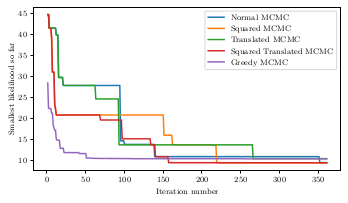

In [64]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

fig = plt.figure(figsize = (5.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Smallest likelihood so far")
plt.plot(range(1, 362), r[1], label = "Normal MCMC")
plt.plot(range(1, 362), rp[1], label = "Squared MCMC")
plt.plot(range(1, 362), rt[1], label = "Translated MCMC")
plt.plot(range(1, 362), rtp[1], label = "Squared Translated MCMC")
plt.plot(range(1, 362), rtg[1], label = "Greedy MCMC")
plt.legend()
plt.savefig('MCMC_AccProb_plot.pgf')

In [47]:
import itertools

def get_permutations(W):
    """@params: Weighted Adjacency Matrix W as numpy array"""
    # tracks the total number of permutations
    total = 0
    
    # iterate over all permutations of the identity matrix
    for perm in tqdm(itertools.permutations(np.identity(np.shape(W)[0])), total = np.math.factorial(p)):
        # convert to numpy array
        P = np.array(perm)
        
        # check if we have an upper triangular matrix
        if np.allclose(P.T @ W @ P, np.triu(P.T @ W @ P)):
            total += 1
            
    # return the number of suitable permutations
    return total

get_permutations(U_true)

100%|██████████████████████████████████████████████████████████████████████| 3628800/3628800 [15:02<00:00, 4020.79it/s]


2940

In [390]:
acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)
print(loss(W_est, X))

{'fdr': 0.3, 'tpr': 0.875, 'fpr': 0.1, 'shd': 18, 'nnz': 50}
50.212175062110994


In [37]:
from timeit import default_timer as timer

# notears versus MCMC greedy
utils.set_random_seed(1)

T, p, s0, graph_type, sem_type = 100, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {p} nodes and {s0} edges, {T} samples.")

B_true = utils.simulate_dag(p, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = utils.simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = utils.simulate_linear_sem(W_true, T, sem_type)
Psi = np.dot(X.T, X)

start = timer()
W_est, h_val = linear.notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)
print(loss(W_est, X))
total_time = timer() - start
print(f"Elapsed time: {round(total_time, 2)}.")
order = h.is_dag(B_true)[1]
P_true = np.zeros((p, p))
for i in range(p):
    P_true[order[-i]][i] = 1
    
np.random.seed(seed = 123)
iters = int(100 * total_time)
Prtg, rg = mcmc(iters, False, acc_prob = acc_prob_greed, P = np.identity(p))
W_mcmc = ols_W(X, Prtg)
W_mcmc[np.abs(W_mcmc) < 0.30] = 0
acc = utils.count_accuracy(B_true, W_mcmc != 0)
print(acc)

SEM based on a graph on 5 nodes and 5 edges, 100 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5 -1.9]
 [-1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.1]
 [ 0.   0.  -0.9  0.   0. ]].



100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 820.78it/s]

Estimated WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.3  0.5 -2. ]
 [-1.8  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.2]
 [ 0.   0.  -0.8  0.   0. ]].

{'fdr': 0.16666666666666666, 'tpr': 1.0, 'fpr': 0.2, 'shd': 1, 'nnz': 6}
4.500213092873578
Elapsed time: 1.23.
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}


In [66]:
T, p, s0, graph_type, sem_type = 1000, 5, 10, 'ER', 'gauss'

Ps = [5, 7, 10, 15, 20, 25, 30, 40, 50]
results_notears = []
results_mcmc = []

for p in Ps:
    res_NT = [[] for i in range(6)]
    res_MCMC = [[] for i in range(6)]
    
    for _ in range(10):
        # generate X, Psi
        B_true = utils.simulate_dag(p, 2 * p, graph_type)
        W_true = utils.simulate_parameter(B_true)
        X = utils.simulate_linear_sem(W_true, T, sem_type)
        Psi = np.dot(X.T, X)

        # do NO TEARS
        start = timer()
        W_est, h_val = linear.notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False)
        total_time = timer() - start
        
        # get score, save score
        acc = utils.count_accuracy(B_true, W_est != 0)
        res_NT[0].append(acc['tpr'])
        res_NT[1].append(acc['shd'])
        res_NT[2].append(acc['fdr'])
        res_NT[3].append(acc['fpr'])
        res_NT[4].append(loss(W_est, X))
        res_NT[5].append(true_loss(W_est, W_true))    
        
        print(f"Elapsed time {round(total_time, 2)} seconds.")

        # get a true permutation matrix
        order = h.is_dag(B_true)[1]
        P_true = np.zeros((p, p))
        for i in range(p):
            P_true[order[-i]][i] = 1

        # do mcmc
        Prtg, rg = mcmc(int(1e10), False, acc_prob = acc_prob_greed, P = np.identity(p), total_time = total_time)
        W_mcmc = ols_W(X, Prtg)
        W_mcmc[np.abs(W_mcmc) < 0.30] = 0
        
        # get results
        acc = utils.count_accuracy(B_true, W_mcmc != 0)
        res_MCMC[0].append(acc['tpr'])
        res_MCMC[1].append(acc['shd'])
        res_MCMC[2].append(acc['fdr'])
        res_MCMC[3].append(acc['fpr'])
        res_MCMC[4].append(loss(W_mcmc, X))    
        res_MCMC[5].append(true_loss(W_mcmc, W_true))    
    results_notears.append(res_NT)
    results_mcmc.append(res_MCMC)

  0%|                                                                 | 211/10000000000 [00:00<2639:09:25, 1052.52it/s]

Elapsed time 2.33 seconds.


  0%|                                                                 | 221/10000000000 [00:00<2515:59:53, 1104.05it/s]

Elapsed time 1.64 seconds.


  0%|                                                                 | 109/10000000000 [00:00<2573:33:56, 1079.35it/s]

Elapsed time 1.36 seconds.


  0%|                                                                 | 222/10000000000 [00:00<2492:06:52, 1114.63it/s]

Elapsed time 1.79 seconds.


  0%|                                                                   | 94/10000000000 [00:00<2955:05:38, 940.00it/s]

Elapsed time 1.56 seconds.


  0%|                                                                 | 225/10000000000 [00:00<2476:31:26, 1121.64it/s]

Elapsed time 1.56 seconds.


  0%|                                                                 | 211/10000000000 [00:00<2636:33:29, 1053.56it/s]

Elapsed time 2.63 seconds.


  0%|                                                                   | 97/10000000000 [00:00<2863:46:52, 969.97it/s]

Elapsed time 1.59 seconds.


  0%|                                                                 | 107/10000000000 [00:00<2613:08:48, 1063.00it/s]

Elapsed time 3.37 seconds.


  0%|                                                                 | 208/10000000000 [00:00<2665:26:36, 1042.14it/s]

Elapsed time 1.63 seconds.


  0%|                                                                   | 81/10000000000 [00:00<3429:25:32, 809.98it/s]

Elapsed time 3.41 seconds.


  0%|                                                                   | 73/10000000000 [00:00<3843:21:23, 722.75it/s]

Elapsed time 3.66 seconds.


  0%|                                                                  | 111/10000000000 [00:00<5015:15:37, 553.87it/s]

Elapsed time 2.97 seconds.


  0%|                                                                   | 58/10000000000 [00:00<4789:19:28, 579.99it/s]

Elapsed time 3.12 seconds.


  0%|                                                                   | 69/10000000000 [00:00<4066:02:05, 683.17it/s]

Elapsed time 3.28 seconds.


  0%|                                                                   | 78/10000000000 [00:00<3596:52:06, 772.28it/s]

Elapsed time 3.51 seconds.


  0%|                                                                   | 77/10000000000 [00:00<3607:34:39, 769.98it/s]

Elapsed time 4.43 seconds.


  0%|                                                                   | 65/10000000000 [00:00<4317:15:03, 643.41it/s]

Elapsed time 3.63 seconds.


  0%|                                                                   | 48/10000000000 [00:00<5844:54:41, 475.25it/s]

Elapsed time 1318.61 seconds.


  0%|                                                                   | 59/10000000000 [00:00<4753:47:25, 584.33it/s]

Elapsed time 3.45 seconds.


  0%|                                                                   | 88/10000000000 [00:00<6313:55:41, 439.94it/s]

Elapsed time 7.98 seconds.


  0%|                                                                   | 49/10000000000 [00:00<5838:21:46, 475.78it/s]

Elapsed time 6.06 seconds.


  0%|                                                                   | 39/10000000000 [00:00<7193:15:42, 386.16it/s]

Elapsed time 6.46 seconds.


  0%|                                                                   | 88/10000000000 [00:00<6588:28:47, 421.61it/s]

Elapsed time 7.11 seconds.


  0%|                                                                   | 72/10000000000 [00:00<7800:28:31, 356.10it/s]

Elapsed time 13.69 seconds.


  0%|                                                                   | 33/10000000000 [00:00<8501:08:51, 326.75it/s]

Elapsed time 12.31 seconds.


  0%|                                                                   | 34/10000000000 [00:00<8414:56:55, 330.10it/s]

Elapsed time 8.65 seconds.


  0%|                                                                   | 37/10000000000 [00:00<7655:55:16, 362.83it/s]

Elapsed time 4.92 seconds.


  0%|                                                                   | 37/10000000000 [00:00<7582:24:31, 366.35it/s]

Elapsed time 7.23 seconds.


  0%|                                                                   | 42/10000000000 [00:00<6679:54:52, 415.84it/s]

Elapsed time 8.15 seconds.


  0%|                                                                  | 21/10000000000 [00:00<13888:13:44, 200.01it/s]

Elapsed time 17.8 seconds.


  0%|                                                                  | 24/10000000000 [00:00<11918:33:20, 233.06it/s]

Elapsed time 14.62 seconds.


  0%|                                                                  | 25/10000000000 [00:00<11111:23:30, 249.99it/s]

Elapsed time 35.19 seconds.


  0%|                                                                  | 22/10000000000 [00:00<12880:35:37, 215.66it/s]

Elapsed time 20.64 seconds.


  0%|                                                                  | 28/10000000000 [00:00<10218:24:43, 271.84it/s]

Elapsed time 35.23 seconds.


  0%|                                                                  | 20/10000000000 [00:00<14443:45:42, 192.32it/s]

Elapsed time 20.86 seconds.


  0%|                                                                  | 22/10000000000 [00:00<12881:53:17, 215.63it/s]

Elapsed time 14.52 seconds.


  0%|                                                                  | 25/10000000000 [00:00<11333:23:09, 245.10it/s]

Elapsed time 39.96 seconds.


  0%|                                                                  | 27/10000000000 [00:00<10494:52:54, 264.68it/s]

Elapsed time 27.03 seconds.


  0%|                                                                  | 42/10000000000 [00:00<13678:35:59, 203.07it/s]

Elapsed time 21.06 seconds.


  0%|                                                                  | 17/10000000000 [00:00<16974:35:04, 163.64it/s]

Elapsed time 37.66 seconds.


  0%|                                                                  | 15/10000000000 [00:00<19237:25:16, 144.39it/s]

Elapsed time 142.01 seconds.


  0%|                                                                  | 15/10000000000 [00:00<19259:08:37, 144.23it/s]

Elapsed time 106.45 seconds.


  0%|                                                                  | 15/10000000000 [00:00<18703:48:18, 148.51it/s]

Elapsed time 47.71 seconds.


  0%|                                                                  | 13/10000000000 [00:00<22009:45:13, 126.21it/s]

Elapsed time 136.8 seconds.


  0%|                                                                  | 16/10000000000 [00:00<18228:52:48, 152.38it/s]

Elapsed time 49.93 seconds.


  0%|                                                                  | 19/10000000000 [00:00<15497:25:00, 179.24it/s]

Elapsed time 49.88 seconds.


  0%|                                                                  | 19/10000000000 [00:00<14912:46:06, 186.27it/s]

Elapsed time 39.51 seconds.


  0%|                                                                  | 18/10000000000 [00:00<15586:50:07, 178.21it/s]

Elapsed time 33.45 seconds.


  0%|                                                                  | 19/10000000000 [00:00<14620:00:30, 190.00it/s]

Elapsed time 100.65 seconds.


  0%|                                                                  | 17/10000000000 [00:00<16993:26:24, 163.46it/s]

Elapsed time 41.33 seconds.


  0%|                                                                  | 14/10000000000 [00:00<20038:59:12, 138.62it/s]

Elapsed time 53.78 seconds.


  0%|                                                                  | 15/10000000000 [00:00<19628:46:50, 141.52it/s]

Elapsed time 56.34 seconds.


  0%|                                                                  | 16/10000000000 [00:00<18576:09:36, 149.53it/s]

Elapsed time 299.7 seconds.


  0%|                                                                  | 16/10000000000 [00:00<18229:52:25, 152.38it/s]

Elapsed time 108.78 seconds.


  0%|                                                                  | 15/10000000000 [00:00<19259:35:06, 144.23it/s]

Elapsed time 102.69 seconds.


  0%|                                                                  | 14/10000000000 [00:00<20634:13:45, 134.62it/s]

Elapsed time 59.47 seconds.


  0%|                                                                  | 15/10000000000 [00:00<19629:39:49, 141.51it/s]

Elapsed time 48.39 seconds.


  0%|                                                                  | 16/10000000000 [00:00<18055:29:19, 153.85it/s]

Elapsed time 67.93 seconds.


  0%|                                                                  | 14/10000000000 [00:00<19841:29:14, 140.00it/s]

Elapsed time 44.2 seconds.


  0%|                                                                   | 10/10000000000 [00:00<28324:15:34, 98.07it/s]

Elapsed time 129.64 seconds.


  0%|                                                                  | 12/10000000000 [00:00<23859:24:29, 116.42it/s]

Elapsed time 145.4 seconds.


  0%|                                                                  | 11/10000000000 [00:00<26768:37:35, 103.77it/s]

Elapsed time 180.14 seconds.


  0%|                                                                    | 7/10000000000 [00:00<40080:37:22, 69.30it/s]

Elapsed time 181.59 seconds.


  0%|                                                                   | 10/10000000000 [00:00<30556:03:22, 90.91it/s]

Elapsed time 424.32 seconds.


  0%|                                                                    | 9/10000000000 [00:00<32340:04:55, 85.89it/s]

Elapsed time 250.71 seconds.


  0%|                                                                   | 10/10000000000 [00:00<29025:36:27, 95.70it/s]

Elapsed time 101.13 seconds.


  0%|                                                                   | 11/10000000000 [00:00<28494:16:16, 97.49it/s]

Elapsed time 234.86 seconds.


  0%|                                                                   | 10/10000000000 [00:00<29089:07:10, 95.49it/s]

Elapsed time 201.52 seconds.


  0%|                                                                   | 10/10000000000 [00:00<29178:39:32, 95.20it/s]

Elapsed time 207.76 seconds.


  0%|                                                                    | 6/10000000000 [00:00<52206:16:24, 53.21it/s]

Elapsed time 663.45 seconds.


  0%|                                                                    | 5/10000000000 [00:00<60205:03:43, 46.14it/s]

Elapsed time 233.38 seconds.


  0%|                                                                    | 6/10000000000 [00:00<55639:16:48, 49.92it/s]

Elapsed time 388.88 seconds.


  0%|                                                                    | 6/10000000000 [00:00<55933:46:16, 49.66it/s]

Elapsed time 321.12 seconds.


  0%|                                                                    | 6/10000000000 [00:00<57457:19:56, 48.35it/s]

Elapsed time 737.15 seconds.


  0%|                                                                    | 4/10000000000 [00:00<87503:15:39, 31.74it/s]

Elapsed time 366.84 seconds.


  0%|                                                                    | 5/10000000000 [00:00<63870:13:04, 43.49it/s]

Elapsed time 167.91 seconds.


  0%|                                                                    | 6/10000000000 [00:00<47671:41:04, 58.27it/s]

Elapsed time 741.33 seconds.


  0%|                                                                    | 5/10000000000 [00:00<56111:16:57, 49.50it/s]

Elapsed time 878.79 seconds.


  0%|                                                                    | 3/10000000000 [00:00<97219:08:57, 28.57it/s]

Elapsed time 343.35 seconds.


  0%|                                                                   | 3/10000000000 [00:00<111113:26:00, 25.00it/s]

Elapsed time 529.08 seconds.


  0%|                                                                    | 4/10000000000 [00:00<91667:08:31, 30.30it/s]

Elapsed time 1050.21 seconds.


  0%|                                                                    | 3/10000000000 [00:00<92593:23:14, 30.00it/s]

Elapsed time 579.16 seconds.


  0%|                                                                    | 4/10000000000 [00:00<72916:30:51, 38.10it/s]

Elapsed time 634.96 seconds.


  0%|                                                                    | 4/10000000000 [00:00<91663:59:46, 30.30it/s]

Elapsed time 813.22 seconds.


  0%|                                                                    | 4/10000000000 [00:00<81871:26:59, 33.93it/s]

Elapsed time 1219.03 seconds.


  0%|                                                                    | 4/10000000000 [00:00<80946:15:12, 34.32it/s]

Elapsed time 708.58 seconds.


  0%|                                                                    | 4/10000000000 [00:00<79860:37:15, 34.78it/s]

Elapsed time 1055.08 seconds.


  0%|                                                                   | 3/10000000000 [00:00<108329:14:03, 25.64it/s]

Elapsed time 1436.13 seconds.


  0%|                                                                    | 4/10000000000 [00:00<86016:17:26, 32.29it/s]

Elapsed time 1417.63 seconds.


  0%|                                                                | 47559/10000000000 [23:37<82797:43:10, 33.55it/s]


In [67]:
r_NT = [[] for _ in range(5)]
for i in range(5):
    for j, metric in enumerate(['tpr', 'fpr', 'shd', 'fdr']):
        r_NT[j].append(results_notears[i][0][metric])
    r_NT[-1].append(results_notears[i][1])
    
print(np.mean(r_NT[-1]))
print(np.median(r_NT[-1]))

r_MCMC = [[] for _ in range(5)]
for i in range(5):
    for j, metric in enumerate(['tpr', 'fpr', 'shd', 'fdr']):
        r_MCMC[j].append(results_mcmc[i][0][metric])
    r_MCMC[-1].append(results_mcmc[i][1])
    
print(np.mean(r_MCMC[-1]))
print(np.median(r_MCMC[-1]))

TypeError: list indices must be integers or slices, not str

In [57]:
print(results_notears)

[[[0.8, 1.0], [2, 0], [0.1111111111111111, 0.0], [1.0, 0.0], [5.007054948348819, 4.146681741321189], [5.476949992248617, 5.091212982142899]], [[0.9, 1.0], [3, 0], [0.25, 0.0], [0.2727272727272727, 0.0], [8.441779497475556, 7.546658420789711], [8.900821649612226, 7.5453743669942135]]]


In [68]:
from scipy.stats import sem
NT_means = [[] for i in range(6)]
NT_sems = [[] for i in range(6)]
for elem in results_notears:
    print(elem)
    for i in range(6):
        NT_means[i].append(np.mean(elem[i]))
        NT_sems[i].append(sem(elem[i]))
        
MCMC_means = [[] for i in range(6)]
MCMC_sems = [[] for i in range(6)]
for elem in results_mcmc:
    for i in range(6):
        MCMC_means[i].append(np.mean(elem[i]))
        MCMC_sems[i].append(sem(elem[i]))

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 1.0], [0, 0, 0, 0, 0, 0, 2, 2, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.1111111111111111, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0], [4.9826783868088835, 4.8504931807913785, 5.012926279873313, 5.135486037560886, 4.883254987436018, 4.991547226826736, 5.332464784564526, 5.424319436742246, 4.946899040983986, 4.80931575206121], [5.0116602531510654, 5.018526571842019, 5.017197772475051, 5.006561971693943, 5.005306158430908, 5.015021388860439, 5.255877310627574, 5.369633501402537, 5.0147156355341345, 5.015390196600475]]
[[0.9285714285714286, 1.0, 1.0, 0.9285714285714286, 0.7857142857142857, 0.7857142857142857, 1.0, 1.0, 1.0, 1.0], [1, 0, 0, 1, 3, 4, 0, 0, 0, 0], [0.07142857142857142, 0.0, 0.0, 0.07142857142857142, 0.08333333333333333, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0], [0.14285714285714285, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.0, 0.0, 0.0, 0.0], [7.294127236709655

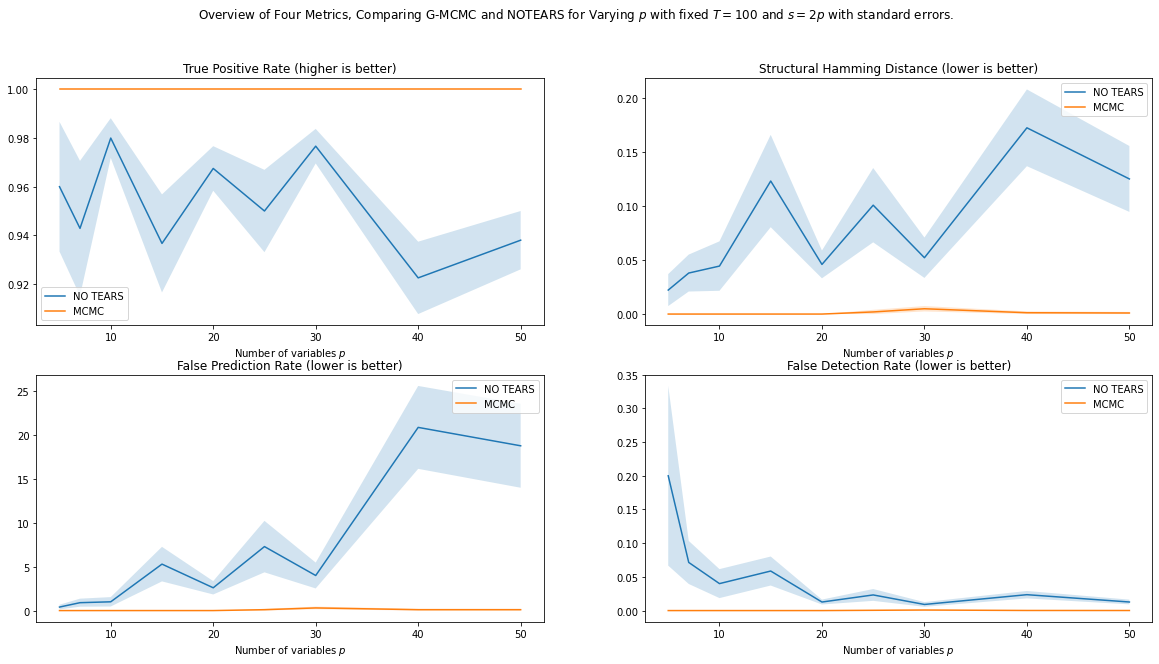

In [69]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Overview of Four Metrics, Comparing G-MCMC and NOTEARS for Varying $p$ with fixed $T = 100$ and $s = 2p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Prediction Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'False Detection Rate (lower is better)']
# Ps = [7, 10, 15, 20, 25, 30, 50]

for i in range(4):
    axs[i % 2, i // 2].plot(Ps, np.array(NT_means)[i, :], label = "NO TEARS")
    axs[i % 2, i // 2].fill_between(Ps, np.array(NT_means)[i, :] - np.array(NT_sems)[i, :], np.array(NT_means)[i, :] + np.array(NT_sems)[i, :], alpha = 0.2)

    axs[i % 2, i // 2].plot(Ps, np.array(MCMC_means)[i, :], label = "MCMC")
    axs[i % 2, i // 2].fill_between(Ps, np.array(MCMC_means)[i, :] - np.array(MCMC_sems)[i, :], np.array(MCMC_means)[i, :] + np.array(MCMC_sems)[i, :], alpha = 0.2)    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')

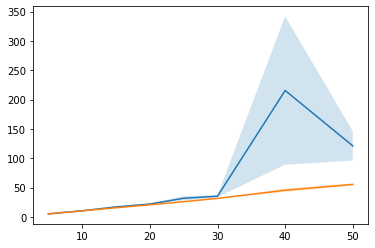

In [70]:
i = -1
plt.plot(Ps, np.array(NT_means)[i, :], label = "NO TEARS")
plt.fill_between(Ps, np.array(NT_means)[i, :] - np.array(NT_sems)[i, :], np.array(NT_means)[i, :] + np.array(NT_sems)[i, :], alpha = 0.2)
plt.plot(Ps, np.array(MCMC_means)[i, :], label = "MCMC")
plt.fill_between(Ps, np.array(MCMC_means)[i, :] - np.array(MCMC_sems)[i, :], np.array(MCMC_means)[i, :] + np.array(MCMC_sems)[i, :], alpha = 0.2)    